# Optimal control of pendulum

## Imports

In [ ]:
from typing import Any, Union, NamedTuple, Callable
import jax
from jax import Array
import jax.random as jr
import jax.numpy as jnp
from jax.experimental.ode import odeint
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from diffilqrax.utils import keygen
from diffilqrax.ilqr import ilqr_solver
from diffilqrax.typs import (
    iLQRParams,
    System,
    ModelDims,
    PendulumParams,
    Theta
)

jax.config.update('jax_enable_x64', True)

## The Problem

We have a pendulum with masses $m_1=1$ and with lengths $L_1$ and $L_2$ which is released from an arbitrary point and has to be driven to the target position.

The cartesian coordinates of the center of mass of each point are defined as
$$
\begin{align}
x_1 =& L_1 \sin(\theta_1) \\
y_1 =& -L_1 \cos(\theta_1) \\
\end{align}
$$

In [2]:
# define coordination function
x1_fn = lambda l_1, the_1: l_1 * jnp.sin(the_1)
y1_fn = lambda l_1, the_1: - l_1 * jnp.cos(the_1)

The dynamics of the double pendulum in polar coordinates are given by the following equations:

$$
% \begin{equation}
\ddot{\theta} = \frac{mgl}{J}\sin\theta - \frac{mgl}{J} u\cos\theta
% \end{equation}
$$

Setting $\frac{mgl}{J}=1$ and initializing system with $\theta=\pi + \epsilon$ and $\dot{\theta}=0$, arrives with simplified dynamics,

$$
% \begin{equation}
\ddot{\theta} = \sin\theta - u\cos\theta
% \end{equation}
$$

Outlined in matrix form, where $\mathbf
{x}=(x_1,x_2)=(\dot{\theta}, \sin\theta)$, 

$$
\frac{d}{dt}\left( \begin{matrix} \dot{\theta} \\ \sin\theta \end{matrix} \right) = 
\left( \begin{matrix} 0 & 1 \\ \cos\theta & 0 \end{matrix} \right) \left( \begin{matrix} \dot{\theta} \\ \sin\theta \end{matrix} \right) + 
\left( \begin{matrix} -\cos\theta \\ 0 \end{matrix} \right) u
$$

In the discretised case,
$$
\delta \mathbf{x} =
\left(\begin{matrix}
0 & \delta t \\
\delta t \cos \theta & 0
\end{matrix}\right)
\mathbf{x} + 
\left(\begin{matrix} -\delta t\cos\theta \\ 0\end{matrix}\right) u
$$
and,
$$\mathbf{x}_{k+t} = \mathbf{x}_{k} + \delta \mathbf{x}_k

In [3]:
# def euler(dynamics:Callable, dt:float)->Callable:
#     return lambda t, x, u: x + dt*dynamics(t*dt, x, u)

# def rk4(dynamics:Callable, dt:float)->Callable:
#     def integrator(t, x, u):
#         dt2 = dt / 2.0
#         k1 = dynamics(t*dt, x, u)
#         k2 = dynamics(t*dt, x + dt2 * k1, u)
#         k3 = dynamics(t*dt, x + dt2 * k2, u)
#         k4 = dynamics(t*dt, x + dt *k3, u)
#         return

In [4]:
# define system dimensions
dims = ModelDims(horizon=10000, n=3, m=1, dt=0.001)

In [5]:
class PendulumParams(NamedTuple):
    """Pendulum parameters"""

    m: float
    l: float
    g: float
    dt: float

def pendulum_step(t:int, state:Array, input:Array, theta: PendulumParams)->Array:
    """simulate the dynamics of a pendulum. x0 is sin(theta), x1 is cos(theta), x2 is theta_dot.
    u is the torque applied to the pendulum.

    Args:
        t (int): timepoint
        state (Array): state params
        u (Array): external input
        theta (Theta): parameters
    """
    d_phi, sin_phi, cos_phi = state
    # const = theta.g * theta.l * theta.m
    dyn_mat = jnp.array(
        [
            [0.,                1.*theta.dt,     0.],
            [theta.dt*cos_phi,  0.,              0.],
            [-theta.dt*sin_phi, 0.,              0.],
    ]
        )
    inp_mat = jnp.array(
        [-cos_phi*theta.dt, 
        0.,
        0.]
        )
    d_state = dyn_mat @ state + inp_mat * input
    
    return d_state + state


def rollout(dyn_step: Callable, Us: Array, state_init:Array, prms: Any)-> Array:
    tps = jnp.arange(Us.shape[0])
    
    def fwd_step(state, inputs):
        t, u = inputs
        x = state
        nx = dyn_step(t, x, u, prms)
        return (nx), (nx, u)
    
    xf, (state_traj, input_traj) = jax.lax.scan(fwd_step, init=state_init, xs=(tps, Us))
    
    return jnp.vstack([state_init[None], state_traj]), input_traj

In [6]:
# Define pendulum parameters
pparams = PendulumParams(1.0, 1.0, 9.8, dims.dt)
tt = jnp.linspace(0., (pparams.dt*dims.horizon), dims.horizon+1)
# init_ang = jnp.pi + 0.2
init_ang = jnp.pi/3. + 0.002
init_state = jnp.array([jnp.pi*0., jnp.sin(init_ang), jnp.cos(init_ang)])
params = iLQRParams(x0=init_state, theta=pparams)

# Define initial control sequence
u_init = jnp.zeros((dims.horizon, 1), dtype=jnp.float64)

# Roll out non-linear pendulum dynamics
init_xs, init_us = rollout(pendulum_step, u_init, init_state, pparams)

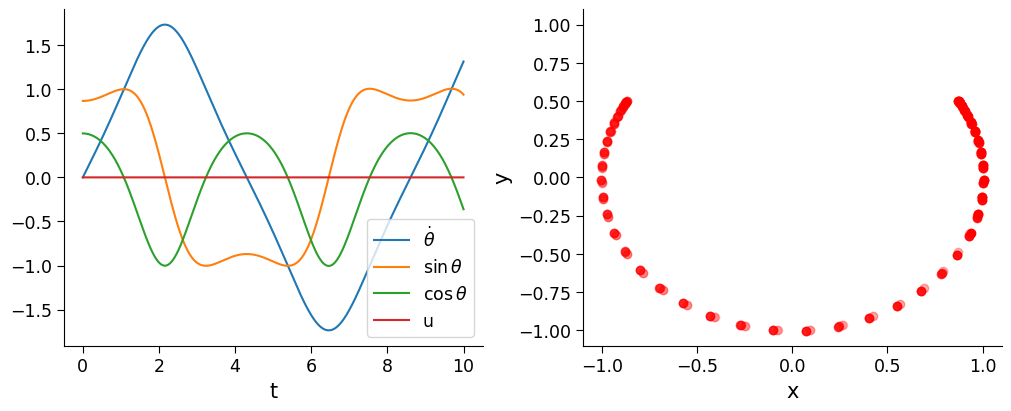

In [7]:
norm = mcolors.Normalize(vmin=tt.min(), vmax=tt.max())
alphas = norm(tt)

fig, ax = plt.subplots(1,2, figsize=(10,4), layout="constrained")
_ = ax[0].plot(tt, init_xs,label=[r'$\dot{\theta}$', r'$\sin\theta$', r'$\cos\theta$'])
_ = ax[0].plot(tt[:-1], init_us, label='u')
_ = ax[0].set(xlabel='t')
_ = ax[0].legend()

for i in range(0,len(tt),100):
    _ = ax[1].scatter(init_xs[i:i+2,1], init_xs[i:i+2,2], color='red', alpha=alphas[i])
_ = ax[1].set(xlabel='x', ylabel='y', xlim=[-pparams.l-0.1, pparams.l+0.1], ylim=[-pparams.l-0.1, pparams.l+0.1])

## Define cost function and target state

In [8]:
def cost(t: int, state: Array, inp: Array, theta: Any):
    d_phi, sin_phi, cos_phi = state
    return(
        jnp.sum(d_phi**2) + 
        jnp.sum((sin_phi-jnp.sin(jnp.pi))**2) + 
        jnp.sum((cos_phi-jnp.cos(jnp.pi))**2 + inp**2)
        )
    

def costf(state: Array, theta: Any):
    d_phi, sin_phi, cos_phi = state
    return(
        jnp.sum(d_phi**2) + 
        jnp.sum((sin_phi-jnp.sin(jnp.pi))**2) + 
        jnp.sum((cos_phi-jnp.cos(jnp.pi))**2)
        )

## Set-up Pendulum model & define iLQR solver

In [9]:
pendulum_problem = System(cost, costf, pendulum_step, dims)

In [10]:
key = jr.PRNGKey(seed=234)
key, skeys = keygen(key, 5)

ls_kwargs = {
    "beta": 0.8,
    "max_iter_linesearch": 16,
    "tol": 1e0,
    "alpha_min": 0.0001,
}


## Solve

In [11]:
# test ilqr solver
(opt_xs, opt_us, opt_lambdas), converged_cost, cost_log = ilqr_solver(
    pendulum_problem,
    params,
    u_init,
    max_iter=40,
    convergence_thresh=1e-8,
    alpha_init=1.0,
    verbose=True,
    use_linesearch=True,
    **ls_kwargs,
)

Converged in 12/40 iterations
old_cost: 8358.033858030298


## Visualise

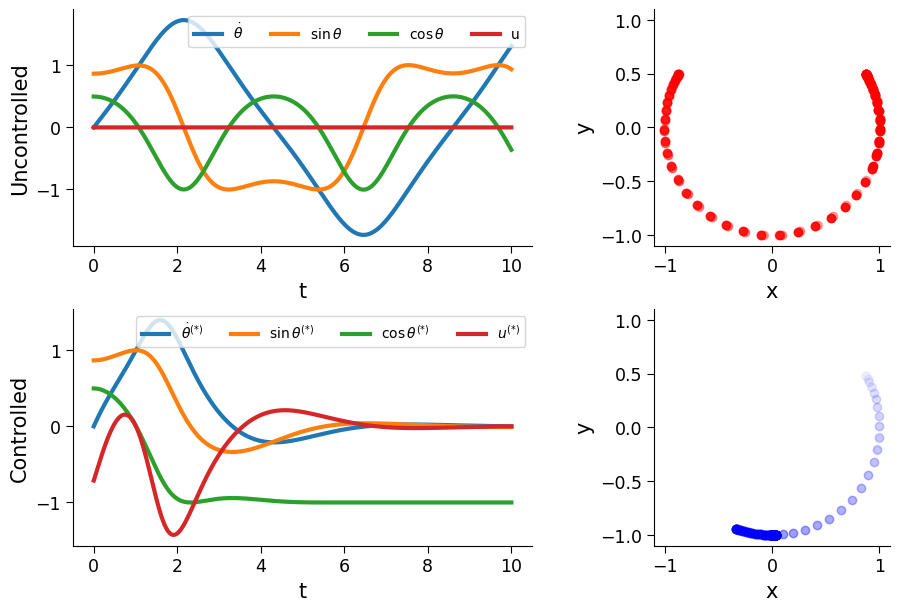

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(10,6), layout="constrained")
_ = ax[0,0].plot(tt, init_xs,label=[r'$\dot{\theta}$', r'$\sin\theta$', r'$\cos\theta$'], lw=3)
_ = ax[0,0].plot(tt[:-1], init_us, label='u', lw=3)
_ = ax[0,0].set(xlabel='t', ylabel="Uncontrolled")
_ = ax[0,0].legend(ncol=4, loc='upper right', prop={'size': 10})

_ = ax[1,0].plot(tt, opt_xs,label=[r'$\dot{\theta}^{(*)}$', r'$\sin\theta^{(*)}$', r'$\cos\theta^{(*)}$'], lw=3)
_ = ax[1,0].plot(tt[:-1], opt_us, label=r'$u^{(*)}$', lw=3)
_ = ax[1,0].set(xlabel='t', ylabel="Controlled")
_ = ax[1,0].legend(ncol=4, loc='upper right', prop={'size': 10})

for i in range(0,len(tt),100):
    _ = ax[0,1].scatter(init_xs[i:i+2,1], init_xs[i:i+2,2], color='red', alpha=alphas[i])
_ = ax[0,1].set(xlabel='x', ylabel='y', xlim=[-pparams.l-0.1, pparams.l+0.1], ylim=[-pparams.l-0.1, pparams.l+0.1], aspect="equal")

for i in range(0,len(tt),100):
    _ = ax[1,1].scatter(opt_xs[i:i+2,1], opt_xs[i:i+2,2], color='blue', alpha=alphas[i])
_ = ax[1,1].set(xlabel='x', ylabel='y', xlim=[-pparams.l-0.1, pparams.l+0.1], ylim=[-pparams.l-0.1, pparams.l+0.1], aspect="equal")

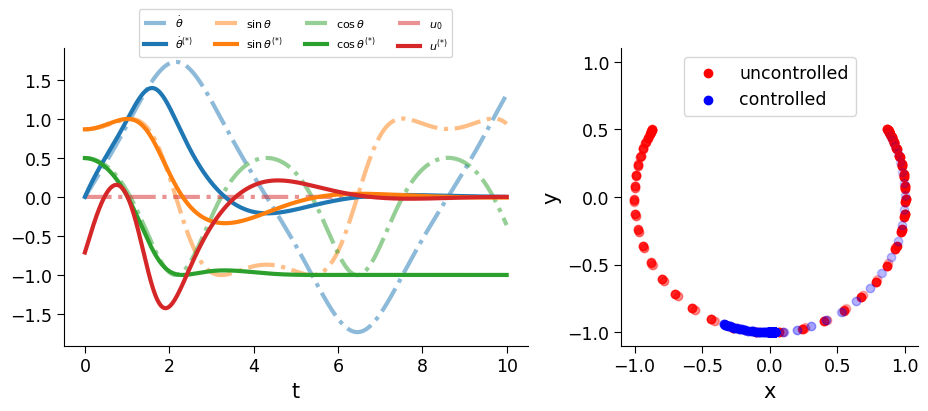

In [13]:
fig, ax = plt.subplots(1,2, figsize=(10,4), layout="constrained")

_ = [ax[0].plot(tt, trj, c=c_, label=l_, lw=3,alpha=.5,ls="-.") for (trj, c_, l_) in zip(init_xs.T, ["C0", "C1", "C2"], [r'$\dot{\theta}$', r'$\sin\theta$', r'$\cos\theta$'])]
_ = ax[0].plot(tt[:-1], init_us, label=r'$u_{0}$', lw=3,alpha=.5, c="C3",ls="-.")
_ = ax[0].set(xlabel='t')


_ = [ax[0].plot(tt, trj, c=c_, label=l_, lw=3,alpha=1.) for (trj, c_, l_) in zip(opt_xs.T, ["C0", "C1", "C2"], [r'$\dot{\theta}^{(*)}$', r'$\sin\theta^{(*)}$', r'$\cos\theta^{(*)}$'])]
_ = ax[0].plot(tt[:-1], opt_us, label=r'$u^{(*)}$', c="C3", lw=3,alpha=1.)
_ = ax[0].set(xlabel='t')
_ = ax[0].legend(ncol=4, loc='upper center', prop={'size': 8})

handles, labels = ax[0].get_legend_handles_labels()
order = [0,4,1,5,2,6,3,7]
_ = ax[0].legend([handles[idx] for idx in order], [labels[idx] for idx in order], ncol=4, loc='upper center', prop={'size': 8}, bbox_to_anchor=(0.5, 1.15))


for i in range(0,len(tt),100):
    _ = ax[1].scatter(init_xs[i:i+2,1], init_xs[i:i+2,2], color='red', alpha=alphas[i])
_ = ax[1].set(xlabel='x', ylabel='y', xlim=[-pparams.l-0.1, pparams.l+0.1], ylim=[-pparams.l-0.1, pparams.l+0.1], aspect="equal")
_ = ax[1].scatter([], [], color='red', label="uncontrolled")

for i in range(0,len(tt),100):
    _ = ax[1].scatter(opt_xs[i:i+2,1], opt_xs[i:i+2,2], color='blue', alpha=alphas[i])
_ = ax[1].set(xlabel='x', ylabel='y', xlim=[-pparams.l-0.1, pparams.l+0.1], ylim=[-pparams.l-0.1, pparams.l+0.1], aspect="equal")
_ = ax[1].scatter([], [], color='blue', label="controlled")
_ = ax[1].legend(loc='upper center')